# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Setup

### Imports

In [1]:
# standard library
import datetime
import math

In [2]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn

### Date this Notebook was run

In [3]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-11-07'

### Set Defaults

In [4]:
# style like ggplot in R
plt.style.use('ggplot')

In [5]:
# Avoid cutting off part of the axis labels, see:
# https://stackoverflow.com/questions/6774086/why-is-my-xlabel-cut-off-in-my-matplotlib-plot
plt.rcParams.update({'figure.autolayout': True})

In [6]:
population_germany = 83_200_000

## Get and Transform Data

In [7]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

### Drop unnecessary / misleading columns

List all columns:

In [8]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_johnson_erst_kumulativ', 'dosen_johnson_zweit_kumulativ',
       'dosen_johnson_dritt_kumulativ', 'dosen_erst_kumulativ',
       'dosen_zweit_kumulativ', 'dosen_dritt_kumulativ',
       'dosen_differenz_zum_vortag', 'dosen_erst_differenz_zum_vortag',
       'dosen_zweit_differenz_zum_vortag', 'dosen_dritt_differenz_zum_vortag',
       'dosen_vollstaendig_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'impf_quote_erst', 'impf_quote_v

Columns with names starting with 'indikation_' will not be analyzed as the data providers stopped updating them.

In [9]:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

Some more columns can be dropped, as there is no interest in analyzing differences on a vaccine level - especially since in some cases vaccines were mixed.

In [10]:
more_cols_to_drop = ['dosen_biontech_erst_kumulativ', 'dosen_biontech_zweit_kumulativ', 
                    'dosen_moderna_erst_kumulativ', 'dosen_moderna_zweit_kumulativ',
                    'dosen_astra_erst_kumulativ', 'dosen_astra_zweit_kumulativ']
vaccinations.drop(columns=more_cols_to_drop, inplace=True)

Some columns are labeled misleadingly. As stated by the data provider the columns `personen_erst_kumulativ` and `impf_quote_erst` contain people vaccinated with the Johnson & Johnson vaccine. As this requires only one shot. the same persons are included in `personen_voll_kumulativ`.
Therefore more columns are dropped and recalculated later.

In [11]:
vaccinations.drop(columns=['impf_quote_erst', 'impf_quote_voll'], inplace=True)

Convert datatype of date column

In [12]:
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

### Show Data

In [13]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date                                     314 non-null    datetime64[ns]
 1   dosen_kumulativ                          314 non-null    int64         
 2   dosen_biontech_kumulativ                 314 non-null    int64         
 3   dosen_biontech_dritt_kumulativ           314 non-null    int64         
 4   dosen_moderna_kumulativ                  314 non-null    int64         
 5   dosen_moderna_dritt_kumulativ            314 non-null    int64         
 6   dosen_astra_kumulativ                    314 non-null    int64         
 7   dosen_astra_dritt_kumulativ              314 non-null    int64         
 8   dosen_johnson_kumulativ                  314 non-null    int64         
 9   dosen_johnson_erst_kumulativ             31

In [14]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_johnson_erst_kumulativ,...,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,dosen_vollstaendig_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ
311,2021-11-03,112550798,86718162,2283853,9808117,88837,12707866,142,3316653,3315645,...,282927,50649,72953,159325,76899,57840650,55652961,2373840,0,0
312,2021-11-04,112837962,86994453,2443983,9815394,94048,12708143,156,3319972,3318938,...,287164,48930,72853,165381,76146,57889580,55729133,2539221,0,0
313,2021-11-05,113066234,87212765,2574415,9821822,98913,12708271,162,3323376,3322339,...,228272,39712,53254,135306,56655,57929292,55785791,2674527,0,0


## Check Validity

In [15]:
# get the last row / the newest available data
last_row = vaccinations.tail(1)

In [16]:
doses_used = last_row['dosen_kumulativ']
doses_used

313    113066234
Name: dosen_kumulativ, dtype: int64

In [17]:
# The number of person having been vaccinated at least once, includes those fully vaccinated
at_least_once = last_row['personen_erst_kumulativ']
fully_vaccinated_people = last_row['personen_voll_kumulativ']
partially_vaccinated_people = at_least_once - fully_vaccinated_people
# The johnson & Johnson vaccine is the only one used in Germany that only needs a single shot:
johnson_doses = last_row['dosen_johnson_kumulativ']

In [18]:
# Must be exactly 0
result_substraction = doses_used - partially_vaccinated_people - (fully_vaccinated_people - johnson_doses) * 2 - johnson_doses
result_substraction

313    2674527
dtype: int64

In [19]:
result_substraction ==  0

313    False
dtype: bool

## Calculate columns

In [20]:
vaccinations['partly vaccinated'] = round(
    (vaccinations['personen_erst_kumulativ'] - vaccinations['personen_voll_kumulativ']) * 100 / population_germany,
    2)

In [21]:
vaccinations['fully vaccinated'] = round(
    vaccinations['personen_voll_kumulativ'] * 100 / population_germany,
    2)

In [22]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date                                     314 non-null    datetime64[ns]
 1   dosen_kumulativ                          314 non-null    int64         
 2   dosen_biontech_kumulativ                 314 non-null    int64         
 3   dosen_biontech_dritt_kumulativ           314 non-null    int64         
 4   dosen_moderna_kumulativ                  314 non-null    int64         
 5   dosen_moderna_dritt_kumulativ            314 non-null    int64         
 6   dosen_astra_kumulativ                    314 non-null    int64         
 7   dosen_astra_dritt_kumulativ              314 non-null    int64         
 8   dosen_johnson_kumulativ                  314 non-null    int64         
 9   dosen_johnson_erst_kumulativ             31

In [23]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_biontech_kumulativ,dosen_biontech_dritt_kumulativ,dosen_moderna_kumulativ,dosen_moderna_dritt_kumulativ,dosen_astra_kumulativ,dosen_astra_dritt_kumulativ,dosen_johnson_kumulativ,dosen_johnson_erst_kumulativ,...,dosen_zweit_differenz_zum_vortag,dosen_dritt_differenz_zum_vortag,dosen_vollstaendig_differenz_zum_vortag,personen_erst_kumulativ,personen_voll_kumulativ,personen_auffrisch_kumulativ,dosen_dim_kumulativ,dosen_kbv_kumulativ,partly vaccinated,fully vaccinated
311,2021-11-03,112550798,86718162,2283853,9808117,88837,12707866,142,3316653,3315645,...,72953,159325,76899,57840650,55652961,2373840,0,0,2.63,66.89
312,2021-11-04,112837962,86994453,2443983,9815394,94048,12708143,156,3319972,3318938,...,72853,165381,76146,57889580,55729133,2539221,0,0,2.60,66.98
313,2021-11-05,113066234,87212765,2574415,9821822,98913,12708271,162,3323376,3322339,...,53254,135306,56655,57929292,55785791,2674527,0,0,2.58,67.05


### Last Update

Often the data is not updated on weekends, so get the highest date in the dataset.

In [24]:
last_update = vaccinations.loc[vaccinations.index[-1], "date"].strftime('%Y-%m-%d')
last_update

'2021-11-05'

## Doses Used

In [25]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
# Rename columns
doses.columns = ['date', 'doses used']

In [26]:
# Scale number of doses as millions
doses['doses used'] = doses['doses used'] / 1_000_000

### Doses Daily

In [27]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-11-05,0.228272


In [28]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

1.428416

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

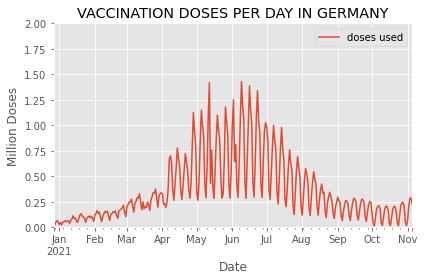

In [29]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily)),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Weekday (in the last 6 weeks)

In [30]:
last_6_weeks = doses.tail(42)

In [31]:
# Yields a warning, but exactly like the docs prescribe and it works
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()

<ipython-input-31-45013977109e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()


In [32]:
# check:
last_6_weeks.tail(3)

,date,doses used,weekday
311,2021-11-03,0.282927,Wednesday
312,2021-11-04,0.287164,Thursday
313,2021-11-05,0.228272,Friday


In [33]:
# drop the date column
last_6_weeks = last_6_weeks.drop(labels=['date'], axis=1)

In [34]:
#last_6_weeks.set_index('weekday', inplace=True)
last_6_weeks.tail(3)

,doses used,weekday
311,0.282927,Wednesday
312,0.287164,Thursday
313,0.228272,Friday


In [35]:
pivot_table =last_6_weeks.pivot(columns='weekday', values='doses used')
pivot_table.tail()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
309,NaN,0.062063,NaN,NaN,NaN,NaN,NaN
310,NaN,NaN,NaN,NaN,NaN,0.208674,NaN
311,NaN,NaN,NaN,NaN,NaN,NaN,0.282927
312,NaN,NaN,NaN,NaN,0.287164,NaN,NaN
313,0.228272,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Reorder the columns
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
# Rename the columns
pivot_table.columns=['Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_table.tail()

,Mo,Tue,Wed,Thu,Fri,Sat,Sun
309,0.062063,NaN,NaN,NaN,NaN,NaN,NaN
310,NaN,0.208674,NaN,NaN,NaN,NaN,NaN
311,NaN,NaN,0.282927,NaN,NaN,NaN,NaN
312,NaN,NaN,NaN,0.287164,NaN,NaN,NaN
313,NaN,NaN,NaN,NaN,0.228272,NaN,NaN


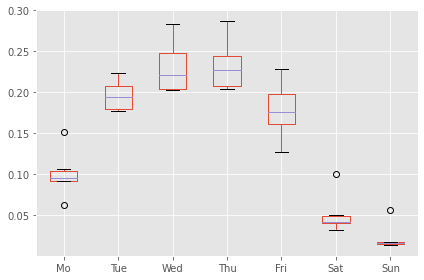

In [37]:
weekday_boxplot = pivot_table.boxplot()

In [38]:
fig = weekday_boxplot.get_figure()
fig.savefig('img/weekday_boxplot.png')

### Doses per Week

In [39]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.columns = ['million doses used']
doses_weekly.tail()

,million doses used
date,
2021-10-11,0.932776
2021-10-18,0.908431
2021-10-25,0.905592
2021-11-01,1.020849
2021-11-08,1.007037


In [40]:
# What is the highest number of doses used in a week?
max_million_doses_weekly = max(doses_weekly['million doses used'])
max_million_doses_weekly

6.125437

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY\n(until 2021-11-05)'}, xlabel='Date', ylabel='Million Doses'>

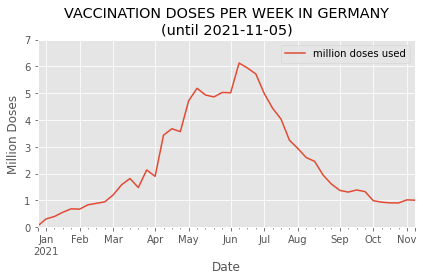

In [41]:
doses_weekly.plot(
    ylim=(0, math.ceil(max_million_doses_weekly)),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER WEEK IN GERMANY\n(until {last_update})")

### Doses per Month

In [42]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2021-07-31,17.266882
2021-08-31,9.271630
2021-09-30,5.877683
2021-10-31,3.973742
2021-11-30,1.069100


In [43]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
June 2021,24.761480
July 2021,17.266882
August 2021,9.271630
September 2021,5.877683
October 2021,3.973742
November 2021,1.069100


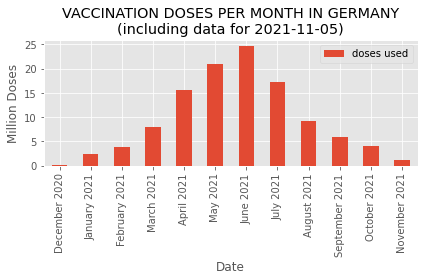

In [44]:
monthly_plot = doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly) + 1),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(including data for {last_update})")

In [45]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_germany.png')

## Vaccination Campaign Progress

In [46]:
doses_cumulative = vaccinations.loc[ : , ['date', 'partly vaccinated', 'fully vaccinated']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.tail(3)

,partly vaccinated,fully vaccinated
date,,
2021-11-03,2.63,66.89
2021-11-04,2.60,66.98
2021-11-05,2.58,67.05


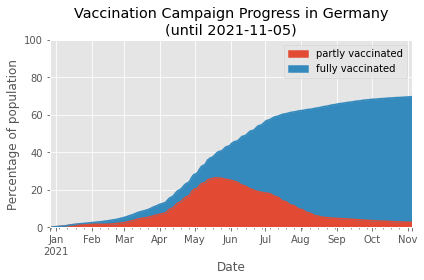

In [47]:
doses_area_plot = doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of population',
    title=f"Vaccination Campaign Progress in Germany\n(until {last_update})")

In [48]:
fig = doses_area_plot.get_figure()
fig.savefig('img/vaccinations_germany_area_plot.png')

### As of Today

In [49]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state

partly vaccinated     2.58
fully vaccinated     67.05
Name: 2021-11-05 00:00:00, dtype: float64

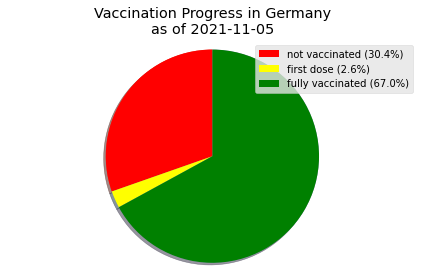

In [50]:
percentage_not_vacc = 100 - current_state['partly vaccinated'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['partly vaccinated'], 1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'], 1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['partly vaccinated'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress in Germany\nas of {last_update}")
# plt.savefig must be before show()
# BEWARE plt.savefig must be in the same Jupyter code cell that creates the graph!
# See comment by ijoseph here:
# https://stackoverflow.com/questions/9012487/matplotlib-pyplot-savefig-outputs-blank-image
plt.savefig('img/vaccination_in_germany_pie.png', bbox_inches='tight')
plt.show()

## Vaccines in Use

In [51]:
vaccinations.columns

Index(['date', 'dosen_kumulativ', 'dosen_biontech_kumulativ',
       'dosen_biontech_dritt_kumulativ', 'dosen_moderna_kumulativ',
       'dosen_moderna_dritt_kumulativ', 'dosen_astra_kumulativ',
       'dosen_astra_dritt_kumulativ', 'dosen_johnson_kumulativ',
       'dosen_johnson_erst_kumulativ', 'dosen_johnson_zweit_kumulativ',
       'dosen_johnson_dritt_kumulativ', 'dosen_erst_kumulativ',
       'dosen_zweit_kumulativ', 'dosen_dritt_kumulativ',
       'dosen_differenz_zum_vortag', 'dosen_erst_differenz_zum_vortag',
       'dosen_zweit_differenz_zum_vortag', 'dosen_dritt_differenz_zum_vortag',
       'dosen_vollstaendig_differenz_zum_vortag', 'personen_erst_kumulativ',
       'personen_voll_kumulativ', 'personen_auffrisch_kumulativ',
       'dosen_dim_kumulativ', 'dosen_kbv_kumulativ', 'partly vaccinated',
       'fully vaccinated'],
      dtype='object')

In [52]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ',
                                     'dosen_moderna_kumulativ',
                                     'dosen_astra_kumulativ',
                                     'dosen_johnson_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'BioNTech', 'Moderna', 'AstraZeneca', 'Johnson & Johnson']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
# divide columns by 1 million
vaccine_use["BioNTech"] = vaccine_use["BioNTech"] / 1_000_000
vaccine_use["Moderna"] = vaccine_use["Moderna"] / 1_000_000
vaccine_use["AstraZeneca"] = vaccine_use["AstraZeneca"] / 1_000_000
vaccine_use["Johnson & Johnson"] = vaccine_use["Johnson & Johnson"] / 1_000_000
vaccine_use.tail(3)

,BioNTech,Moderna,AstraZeneca,Johnson & Johnson
date,,,,
2021-11-03,86.718162,9.808117,12.707866,3.316653
2021-11-04,86.994453,9.815394,12.708143,3.319972
2021-11-05,87.212765,9.821822,12.708271,3.323376


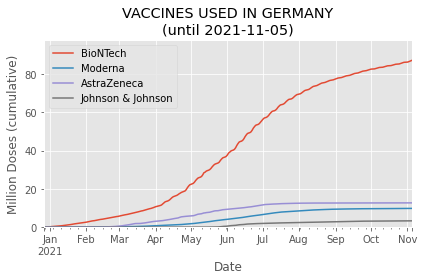

In [53]:
vaccines_used = vaccine_use.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0,math.ceil(max(vaccine_use.iloc[-1]))+10),
    xlabel='Date',
    ylabel='Million Doses (cumulative)',
    title=f"VACCINES USED IN GERMANY\n(until {last_update})")

In [54]:
fig = vaccines_used.get_figure()
fig.savefig('img/vaccines_used_in_germany.png')